# Intro to Random Forests

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics, linear_model
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.collections import EllipseCollection
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

In [3]:
#os.listdir()

In [4]:
df_raw = pd.read_csv('./Data/train.csv', low_memory=False)

In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [6]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,1460,NaN,NaN,NaN,730.5,421.61,1,365.75,730.5,1095.25,1460
MSSubClass,1460,NaN,NaN,NaN,56.8973,42.3006,20,20,50,70,190
MSZoning,1460,5,RL,1151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,1201,NaN,NaN,NaN,70.05,24.2848,21,59,69,80,313
LotArea,1460,NaN,NaN,NaN,10516.8,9981.26,1300,7553.5,9478.5,11601.5,215245
Street,1460,2,Pave,1454,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alley,91,2,Grvl,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotShape,1460,4,Reg,925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LandContour,1460,4,Lvl,1311,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Utilities,1460,2,AllPub,1459,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Removing some outliers that appear to be errors

In [7]:
df_raw = df_raw.drop(df_raw[(df_raw['GrLivArea']>4000) & (df_raw['SalePrice']<300000)].index)

Changing the target variable to be log (what is used in Kaggle) and dropping the Id variable

In [8]:
df_raw.SalePrice = np.log(df_raw.SalePrice)
df_raw.drop('Id', axis = 1, inplace = True)

The distribution of the logged price seems to be normally distributed around 12

C:\Users\skimel\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


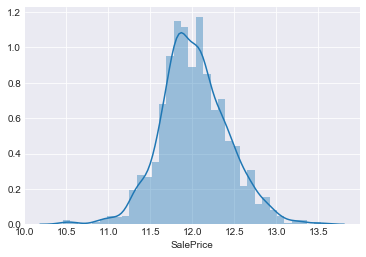

In [9]:
sns.distplot(df_raw['SalePrice'])

### Initial processing

This dataset contains a mix of **continuous** and **categorical** variables.

The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals.  You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.

In [10]:
df_raw.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [11]:
np.unique(df_raw['YrSold'])

array([2006, 2007, 2008, 2009, 2010], dtype=int64)

When TotalBsmtSF is NA, this means that there is no SF so setting it to 0

In [12]:
df_raw['TotalBsmtSF'] = df_raw['TotalBsmtSF'].fillna(0)

Creating the variable age to determine how old the house was when it was sold. YearRemodAdd is either the year built or the year it was remodeled. Basing the age on either year built or year remodeled, whichever is later.
Also creating TotalSF, which adds up all the SF from every floor.

In [13]:
df_raw['age'] = df_raw['YrSold'] - df_raw['YearRemodAdd']
df_raw['TotalSF'] = df_raw['TotalBsmtSF'] + df_raw['1stFlrSF'] + df_raw['2ndFlrSF']

In [14]:
np.unique(df_raw['YearRemodAdd'])

array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966,
       1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010], dtype=int64)

The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

In [15]:
train_cats(df_raw)

In [16]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

1stFlrSF         0.000000
2ndFlrSF         0.000000
3SsnPorch        0.000000
Alley            0.937586
BedroomAbvGr     0.000000
BldgType         0.000000
BsmtCond         0.025377
BsmtExposure     0.026063
BsmtFinSF1       0.000000
BsmtFinSF2       0.000000
BsmtFinType1     0.025377
BsmtFinType2     0.026063
BsmtFullBath     0.000000
BsmtHalfBath     0.000000
BsmtQual         0.025377
BsmtUnfSF        0.000000
CentralAir       0.000000
Condition1       0.000000
Condition2       0.000000
Electrical       0.000686
EnclosedPorch    0.000000
ExterCond        0.000000
ExterQual        0.000000
Exterior1st      0.000000
Exterior2nd      0.000000
Fence            0.807270
FireplaceQu      0.473251
Fireplaces       0.000000
Foundation       0.000000
FullBath         0.000000
Functional       0.000000
GarageArea       0.000000
GarageCars       0.000000
GarageCond       0.055556
GarageFinish     0.055556
GarageQual       0.055556
GarageType       0.055556
GarageYrBlt      0.055556
GrLivArea   

In [17]:
?proc_df

### Pre-processing

In the future we can simply read it from this fast format.

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable. This function puts the median for missings of continuous variables.

In [18]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [19]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [20]:
df_raw.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,age,TotalSF
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,0,2,2008,WD,Normal,12.247694,5,2566
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,0,5,2007,WD,Normal,12.109011,31,2524
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,0,9,2008,WD,Normal,12.317167,6,2706
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,0,2,2006,WD,Abnorml,11.849398,36,2473
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,0,12,2008,WD,Normal,12.429216,8,3343


In [21]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,age,TotalSF,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,60,4,65.0,8450,2,0,4,4,1,5,...,0,2,2008,9,5,5,2566,False,False,False
1,20,4,80.0,9600,2,0,4,4,1,3,...,0,5,2007,9,5,31,2524,False,False,False
2,60,4,68.0,11250,2,0,1,4,1,5,...,0,9,2008,9,5,6,2706,False,False,False
3,70,4,60.0,9550,2,0,1,4,1,1,...,0,2,2006,9,1,36,2473,False,False,False
4,60,4,84.0,14260,2,0,1,4,1,3,...,0,12,2008,9,5,8,3343,False,False,False


We now have something we can pass to a random forest! This is before the data is split to just see if the code works.

In [22]:
m = RandomForestRegressor(n_jobs=-1) #random forrests are trivially paralyzable. If I have more than one CPU, 
#it will split up data acrooss CPUs and linearly scale. n_jobs=-1 says create a different job for each CPU.
m.fit(df, y)
m.score(df,y)

0.9748937402848554

Now we will split into train and validation (The test set is the one on Kaggle)

In [23]:
len(df)

1458

In [24]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 400  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((1058, 84), (1058,), (400, 84))

## Base model

Let's try our model again, this time with separate training and validation sets.

In [25]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [26]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 114 ms
[0.0647690083630718, 0.14358526967030844, 0.9746817589688309, 0.8563479058773924]


# Predicting

Bringing in the test data from Kaggle

In [27]:
df_test = pd.read_csv('./Data/test.csv', low_memory=False)

In [28]:
df_test['TotalBsmtSF'] = df_test['TotalBsmtSF'].fillna(0)
df_test['age'] = df_test['YrSold'] - df_test['YearRemodAdd']
df_test['TotalSF'] = df_test['TotalBsmtSF'] + df_test['1stFlrSF'] + df_test['2ndFlrSF']

In [29]:
df_id = df_test['Id']
df_id = pd.DataFrame(df_id, columns = ['Id'])

In [30]:
df_test.drop('Id', axis = 1, inplace = True)

In [31]:
display_all(df_test.isnull().sum().sort_index()/len(df_test))

1stFlrSF         0.000000
2ndFlrSF         0.000000
3SsnPorch        0.000000
Alley            0.926662
BedroomAbvGr     0.000000
BldgType         0.000000
BsmtCond         0.030843
BsmtExposure     0.030158
BsmtFinSF1       0.000685
BsmtFinSF2       0.000685
BsmtFinType1     0.028787
BsmtFinType2     0.028787
BsmtFullBath     0.001371
BsmtHalfBath     0.001371
BsmtQual         0.030158
BsmtUnfSF        0.000685
CentralAir       0.000000
Condition1       0.000000
Condition2       0.000000
Electrical       0.000000
EnclosedPorch    0.000000
ExterCond        0.000000
ExterQual        0.000000
Exterior1st      0.000685
Exterior2nd      0.000685
Fence            0.801234
FireplaceQu      0.500343
Fireplaces       0.000000
Foundation       0.000000
FullBath         0.000000
Functional       0.001371
GarageArea       0.000685
GarageCars       0.000685
GarageCond       0.053461
GarageFinish     0.053461
GarageQual       0.053461
GarageType       0.052090
GarageYrBlt      0.053461
GrLivArea   

There are some missing values in the test that were not missing in the training set. Because of this, I am filling in these missing with 0. There are very few observations that have these variables missing.

In [32]:
df_test['BsmtFinSF1'] = df_test['BsmtFinSF1'].fillna(0)
df_test['BsmtFinSF2'] = df_test['BsmtFinSF2'].fillna(0)
df_test['BsmtUnfSF'] = df_test['BsmtUnfSF'].fillna(0)
df_test['BsmtFullBath'] = df_test['BsmtFullBath'].fillna(0)
df_test['BsmtHalfBath'] = df_test['BsmtHalfBath'].fillna(0)
df_test['GarageCars'] = df_test['GarageCars'].fillna(0)
df_test['GarageArea'] = df_test['GarageArea'].fillna(0)

This will apply all the category levels that we had for the training set.

In [33]:
apply_cats(df_test, df_raw)

In [34]:
df_test['y'] = 0

Putting the same medians in as the train set and changing the categories to numbers in the same way as the train

In [35]:
nas

{'LotFrontage': 69.0, 'MasVnrArea': 0.0, 'GarageYrBlt': 1980.0}

In [36]:
df_t, _, nas_t = proc_df(df_test, 'y', na_dict = nas)

In [37]:
df_t.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [38]:
np.unique(df_test[['GarageCars']])

array([0., 1., 2., 3., 4., 5.])

In [39]:
pred = m.predict(df_t)

pred = np.exp(pred)
pred2 = pd.DataFrame(pred, columns = ['SalePrice'])

final_pred = pd.concat([df_id[['Id']], pred2[['SalePrice']]], axis = 1)

final_pred.to_csv('pred.csv', encoding='utf-8', index=False)

## Bagging

### Intro to bagging

To learn about bagging in random forests, let's start with our basic model again.

In [40]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=80)
m.fit(X_train, y_train)
print_score(m)

[0.052833143510641056, 0.13441523896305133, 0.9831534126860823, 0.8741105888883837]


We'll grab the predictions for each individual tree, and look at one example.

In [41]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([12.28995, 12.05815, 11.68688, 11.84223, 11.76757, 12.25486, 12.01974, 12.12811, 12.05815, 12.08108,
        11.96718, 12.07254, 11.95118, 12.25486, 11.93819, 12.06105, 12.03469, 12.25961, 11.88449, 12.12811,
        12.15478, 12.16525, 12.18075, 12.20919, 12.05757, 11.98293, 12.15478, 11.88449, 11.8678 , 11.95118,
        12.18075, 11.88449, 12.22588, 12.02575, 12.20657, 11.87027, 11.93164, 12.07254, 11.89478, 12.05815,
        11.94406, 11.79434, 11.97035, 11.70767, 12.14153, 12.06105, 12.15478, 12.10625, 11.81303, 12.01974,
        11.95118, 12.03765, 11.85652, 12.1442 , 12.07824, 11.88449, 12.05234, 12.00151, 11.88449, 12.08391,
        12.07254, 12.39462, 11.92437, 11.92338, 11.76757, 12.27839, 12.25961, 12.01974, 12.19552, 12.02874,
        11.97666, 12.13886, 12.15478, 12.17303, 12.19552, 12.08108, 12.25961, 11.8494 , 12.12811, 11.95118]),
 12.039477729659092,
 12.301382825334498)

In [42]:
preds.shape

(80, 400)

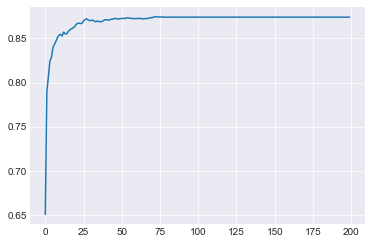

In [43]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(200)]);

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)

In [44]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.05768014048832132, 0.1423530239236562, 0.979920557376046, 0.8588029643141946]


In [45]:
m = RandomForestRegressor(n_estimators=100, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.05266211554066251, 0.1348769098338947, 0.9832623054742811, 0.8732443287102628]


In [46]:
m = RandomForestRegressor(n_estimators=800, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.05204205722744268, 0.13421333242633224, 0.9836541335566537, 0.8744885044426034]


In [47]:
m = RandomForestRegressor(n_estimators=800, n_jobs=-1)
m.fit(df, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [48]:
pred = m.predict(df_t)

pred = np.exp(pred)
pred2 = pd.DataFrame(pred, columns = ['SalePrice'])

final_pred = pd.concat([df_id[['Id']], pred2[['SalePrice']]], axis = 1)

final_pred.to_csv('pred2.csv', encoding='utf-8', index=False)

### Out-of-bag (OOB) score

Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called *out-of-bag (OOB) error* which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was *not* included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our `print_score` function below.

In [49]:
m = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.05304166129796381, 0.13405864535947565, 0.9830201726429177, 0.874777653313413, 0.8773037024363987]


This shows that our validation set time difference is making an impact, as is model over-fitting.

## Reducing over-fitting

### Subsampling

It turns out that one of the easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: *subsampling*. Let's return to using our full dataset, so that we can demonstrate the impact of this technique.

In [50]:
df_trn, y_trn, _ = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit it to a *different* random subset per tree. That way, given enough trees, the model can still see *all* the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.

In [51]:
set_rf_samples(300)

In [52]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True, n_estimators = 100)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 480 ms
[0.10840939503383673, 0.1396824598540495, 0.929069523716778, 0.8640510260880505, 0.8760116299503757]


Since each additional tree allows the model to see more data, this approach can make additional trees more useful.

### Tree building parameters

We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [53]:
reset_rf_samples()

Let's get a baseline for this full set to compare to.

In [54]:
m = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.0527355408411312, 0.13351751042886353, 0.9832155991467313, 0.8757865464414987, 0.8771072725883077]


Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [55]:
m = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07355468073352239, 0.13527243724688473, 0.9673472574789456, 0.872499815006356, 0.878045805622521]


We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of *columns* for each *split*. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.

- None
- 0.5
- 'sqrt'

- 1, 3, 5, 10, 25, 100

In [56]:
m = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, max_features=.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.0501864014863791, 0.13095924210254933, 0.9847990354060038, 0.8805009394344705, 0.8850935598409899]


In [57]:
m = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, max_features=.5, n_jobs=-1, oob_score=True)
m.fit(df, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [58]:
pred = m.predict(df_t)

pred = np.exp(pred)
pred2 = pd.DataFrame(pred, columns = ['SalePrice'])

final_pred = pd.concat([df_id[['Id']], pred2[['SalePrice']]], axis = 1)

final_pred.to_csv('pred3.csv', encoding='utf-8', index=False)

# Looking at Variables

In [59]:
m = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, max_features=.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.05272538297066726, 0.13264636164838814, 0.9832220645151255, 0.8774021456210513, 0.8834279098537494]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [60]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 180 ms


(12.029182554794156, 0.1668903467795154)

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [61]:
fi = rf_feat_importance(m, X_train); fi[:10]

,cols,imp
80,TotalSF,0.326511
16,OverallQual,0.244454
18,YearBuilt,0.056401
45,GrLivArea,0.054569
60,GarageCars,0.036285
26,ExterQual,0.028268
61,GarageArea,0.022069
48,FullBath,0.017442
58,GarageYrBlt,0.015366
42,1stFlrSF,0.014744


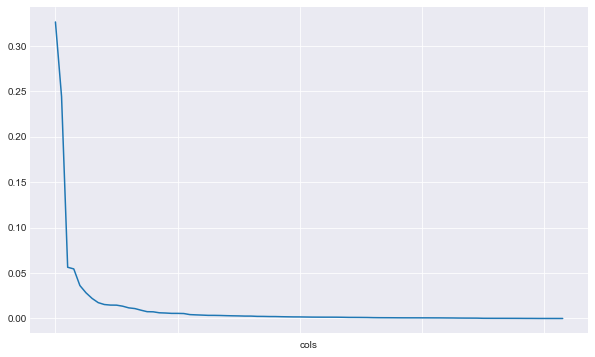

In [62]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [63]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

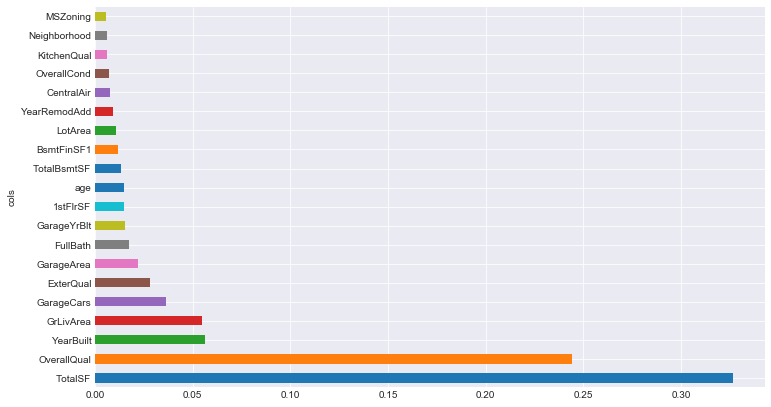

In [64]:
plot_fi(fi[:20]);

In [65]:
to_keep = fi[fi.imp>0.002].cols; len(to_keep)

37

In [66]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [67]:
m = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, max_features=.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.048884088720861064, 0.1308766514805138, 0.9855777147311006, 0.880651618217295, 0.890358396167261]


In [70]:
m.fit(df[to_keep], y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [71]:
df_t2 = df_t[to_keep]
pred = m.predict(df_t2)

pred = np.exp(pred)
pred2 = pd.DataFrame(pred, columns = ['SalePrice'])

final_pred = pd.concat([df_id[['Id']], pred2[['SalePrice']]], axis = 1)

final_pred.to_csv('pred5.csv', encoding='utf-8', index=False)

In [ ]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

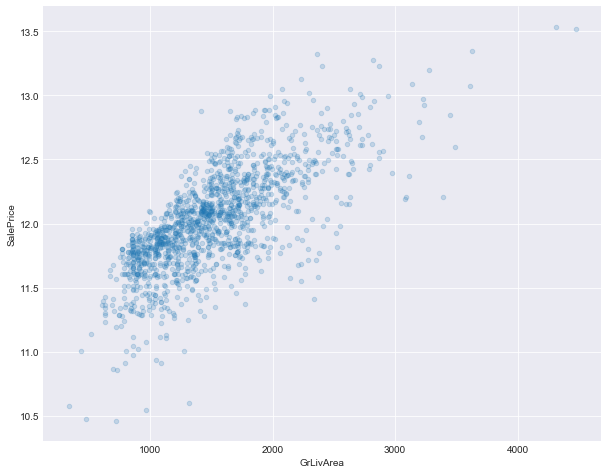

In [59]:
df_raw.plot('GrLivArea', 'SalePrice', 'scatter', alpha=0.2, figsize=(10,8));

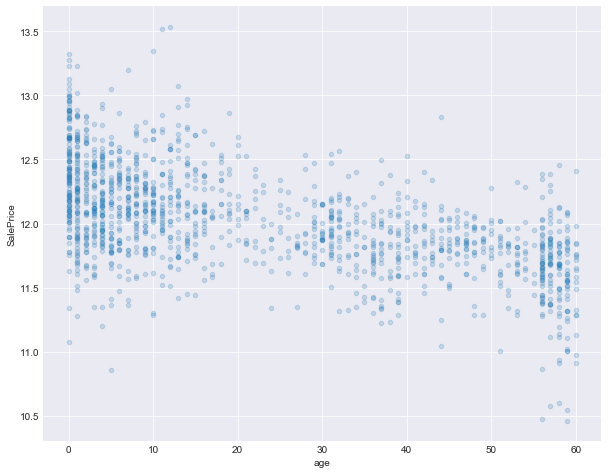

In [60]:
df_raw.plot('age', 'SalePrice', 'scatter', alpha=0.2, figsize=(10,8));

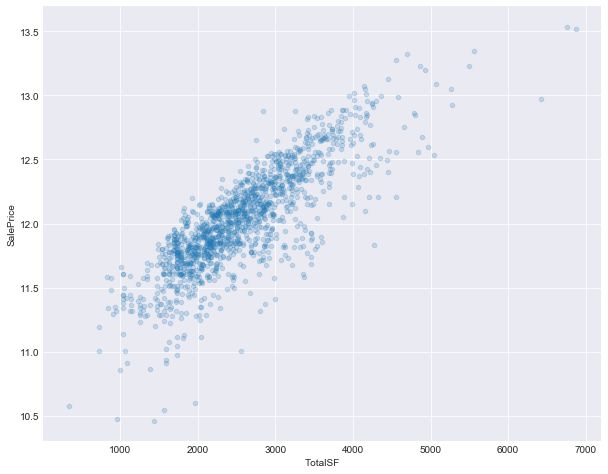

In [61]:
df_raw.plot('TotalSF', 'SalePrice', 'scatter', alpha=0.2, figsize=(10,8));

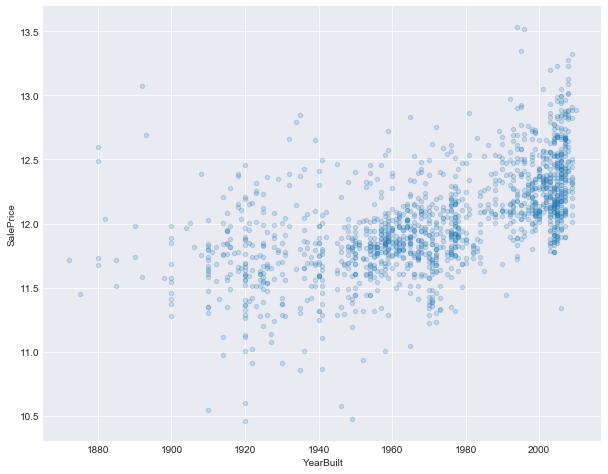

In [62]:
df_raw.plot('YearBuilt', 'SalePrice', 'scatter', alpha=0.2, figsize=(10,8));

In [63]:
def plot_corr_ellipses(data, ax=None, **kwargs):

    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    if ax is None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'aspect':'equal'})
        ax.set_xlim(-0.5, M.shape[1] - 0.5)
        ax.set_ylim(-0.5, M.shape[0] - 0.5)

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel()
    h = 1 - np.abs(M).ravel()
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec

In [64]:
df_raw.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

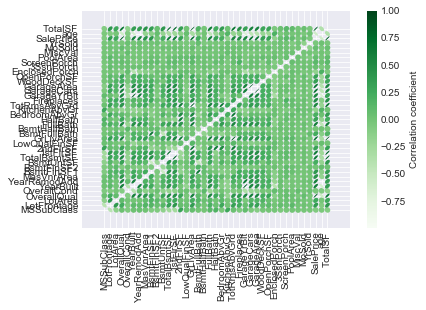

In [65]:

data = df_raw.corr()
fig, ax = plt.subplots(1, 1)
m = plot_corr_ellipses(data, ax=ax, cmap='Greens')
cb = fig.colorbar(m)
cb.set_label('Correlation coefficient')
ax.margins(0.1)

## One-hot encoding

In [113]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, max_features=.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.052157627416815296, 0.12903255784433612, 0.9835814541683012, 0.8839912364409865, 0.8846170318736274]


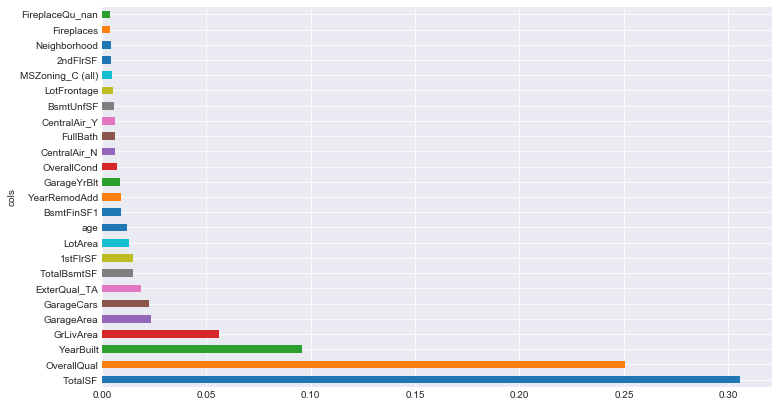

In [114]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);


# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [115]:
from scipy.cluster import hierarchy as hc

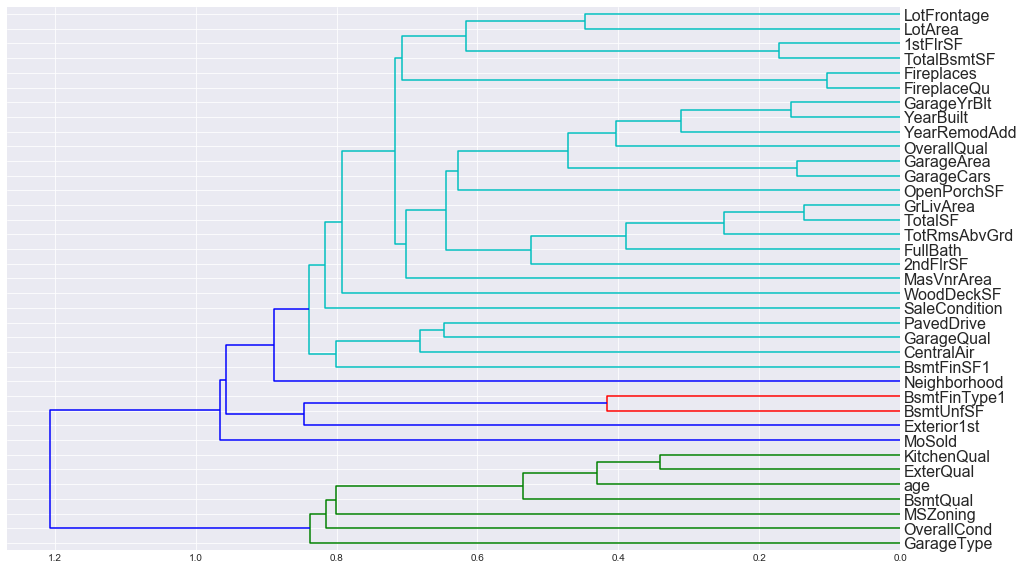

In [116]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [117]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=1000, min_samples_leaf=1, max_features=0.5, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [118]:
get_oob(df_keep)

0.8885398078819142

In [119]:
#for c in ('TotalBsmtSF', '1stFlrSF'):
#    print(c, get_oob(df_keep.drop(c, axis=1)))

Now we try removing each variable one at a time.

In [120]:
for c in ('GarageCars', 'GarageArea','TotalSF', 'GrLivArea','Fireplaces','FireplaceQu'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

GarageCars 0.8897267373403315
GarageArea 0.8896261296690926
TotalSF 0.8872542325023989
GrLivArea 0.8890575930071936
Fireplaces 0.8892167089475687
FireplaceQu 0.8892430024213736



It looks like we can try one from each group for removal. Let's see what that does.

In [121]:
to_drop = ['GarageCars', 'TotalSF','FireplaceQu']
get_oob(df_keep.drop(to_drop, axis=1))

0.888594062327117

In [423]:
#to_drop = ['TotalBsmtSF']
#get_oob(df_keep.drop(to_drop, axis=1))

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [122]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [87]:
#np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [88]:
#keep_cols = np.load('tmp/keep_cols.npy')
#df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [123]:
reset_rf_samples()

In [165]:
m = RandomForestRegressor(n_estimators=800, min_samples_leaf=1, max_features=.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.05013644974771351, 0.1322387062964957, 0.9848292801219543, 0.8781545352670764, 0.8876040918459507]


In [ ]:
df_keep_all.drop(to_drop, axis=1, inplace=True)
m = RandomForestRegressor(n_estimators=800, min_samples_leaf=1, max_features=.5, n_jobs=-1, oob_score=True)
m.fit(df_keep_all, y)

### Which have the worst errors

In [97]:
X_valid.shape

(400, 19)

In [166]:
errors = m.predict(X_valid) - y_valid
errors = pd.DataFrame(errors, columns = ['ErrorSalePrice'])
errors.index = range(1059, 1459)

id_errors = pd.concat([X_valid, errors[['ErrorSalePrice']]], axis = 1, join_axes=[X_valid.index])

In [167]:
id_errors['is_bad'] = 1
mask = abs(id_errors.ErrorSalePrice) < .1
column_name = 'is_bad'
id_errors.loc[mask, column_name] = 0

In [179]:
id_errors.groupby(['is_bad']).size()

is_bad
0    264
1    136
dtype: int64

In [175]:
id_errors.head()

,OverallQual,GrLivArea,YearBuilt,age,ExterQual,TotalBsmtSF,GarageArea,BsmtFinSF1,LotArea,CentralAir,...,SaleCondition,MasVnrArea,GarageQual,GarageType,PavedDrive,Exterior1st,WoodDeckSF,BsmtQual,ErrorSalePrice,is_bad
1059,6,1991,1932,57,4,854,432,297,11275,2,...,5,480.0,5,6,3,9,0,4,-0.291101,1
1060,8,1338,2001,9,3,1338,582,616,4920,2,...,5,0.0,5,2,3,6,0,3,-0.046676,0
1061,3,894,1935,58,2,894,1248,0,18000,2,...,5,0.0,5,6,3,9,0,4,0.219366,1
1062,5,2337,1900,57,4,662,560,0,13600,1,...,5,0.0,5,6,3,14,0,4,0.417745,1
1063,6,1103,1925,26,4,1103,440,397,6000,2,...,5,0.0,5,6,3,9,166,4,0.102449,1


In [168]:
m2 = RandomForestClassifier(n_estimators=1000, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True) 
m2.fit(X_valid, id_errors['is_bad'])
m2.score(X_valid, id_errors['is_bad'])

0.97

In [169]:
fi2 = rf_feat_importance(m2, X_valid); fi2[:10]

,cols,imp
17,LotFrontage,0.082798
19,BsmtUnfSF,0.075218
8,LotArea,0.057259
2,YearBuilt,0.055220
10,1stFlrSF,0.055160
1,GrLivArea,0.055148
5,TotalBsmtSF,0.054242
3,age,0.051559
6,GarageArea,0.047665
7,BsmtFinSF1,0.045977


In [170]:
bad = id_errors.loc[id_errors['is_bad'] == 1]

In [171]:
bad.YearBuilt.median()

1966.5

In [172]:
X_train.YearBuilt.median()

1974.0

In [173]:
X_train.shape

(1058, 34)

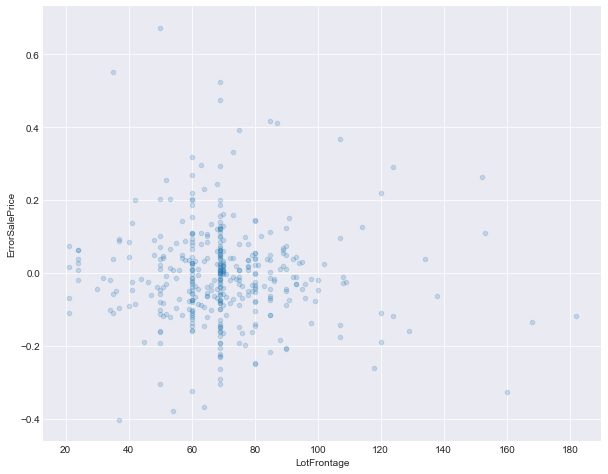

In [174]:
id_errors.plot('LotFrontage', 'ErrorSalePrice', 'scatter', alpha=0.2, figsize=(10,8));

# Extrapolation

In [107]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1

df_ext.is_valid[:n_trn] = 0

C:\Users\skimel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [108]:
x, y, nas = proc_df(df_ext, 'is_valid')

In [109]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.6934156378600823

In [110]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
12,LotArea,0.112396
0,TotalSF,0.104397
18,BsmtUnfSF,0.101396
7,1stFlrSF,0.091782
4,TotalBsmtSF,0.090291
9,BsmtFinSF1,0.082201
15,LotFrontage,0.078117
10,GarageYrBlt,0.064595
5,age,0.064261
2,YearBuilt,0.060714


In [111]:
feats=['LotArea', 'BsmtUnfSF', 'TotalSF', 'LotFrontage', 'TotalBsmtSF', '1stFlrSF']

In [112]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.0848126160116031, 0.13483614166517394, 0.9565869845926203, 0.8733209439828946, 0.8687057397885436]


In [113]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

LotArea
[0.08720271406021492, 0.13924383837597737, 0.9541056695712143, 0.8649034812447238, 0.8671083453671721]
BsmtUnfSF
[0.08335652926316546, 0.13847336636118085, 0.958064842230946, 0.8663943926575852, 0.8702347533839198]
TotalSF
[0.09350576237768794, 0.15241644636280663, 0.9472313741019323, 0.8381339203133198, 0.842624494665503]
LotFrontage
[0.08518448735284574, 0.13505119694864792, 0.9562054505749831, 0.8729165312577428, 0.8757983879770781]
TotalBsmtSF
[0.08256405643633087, 0.13241261350402736, 0.958858409388642, 0.8778338464388399, 0.8754389828635785]
1stFlrSF
[0.08464289684027683, 0.13556733540538715, 0.9567605589791774, 0.871943300247689, 0.8743558608166826]


In [114]:
reset_rf_samples()

In [115]:
df_subs = df_keep.drop(['LotArea'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.0873173663267663, 0.13655399188888617, 0.9539849084648218, 0.8700725287708145, 0.870547328221529]


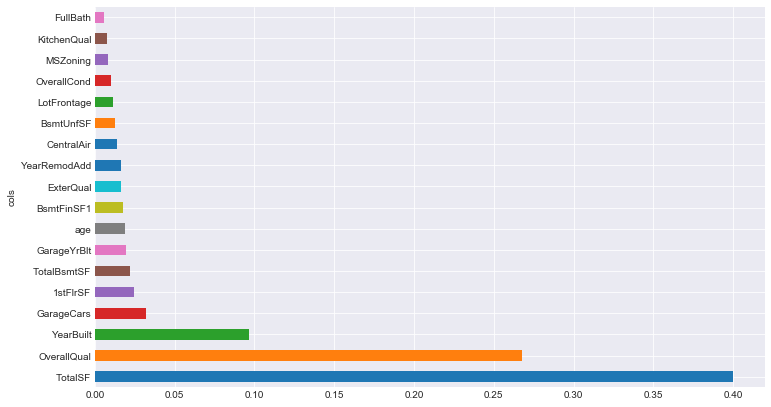

In [116]:
plot_fi(rf_feat_importance(m, X_train));

In [468]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

FileNotFoundError: [Errno 2] No such file or directory: 'tmp/subs_cols.npy'

# Our final model!

In [117]:
m = RandomForestRegressor(n_estimators=1000, max_features=.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 2.53 s
[0.05144599076254243, 0.134004083477445, 0.9840264257404299, 0.8748795635856257, 0.8826396541436838]
